In [15]:
import os
import sys
import urllib, io

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pickle

In [3]:
experiment_name = 'perceptual_chunks'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [4]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['perceptual_chunks']

# latest iteration name to include
iteration_name = 'pilot_0b'

# variables to check integrity of data
numTrials = 8

In [7]:
# load csvs outputted from data generator

# trial_path = os.path.join(csv_dir,'perceptual_chunks_trial_{}.csv'.format(iteration_name))
# df_trial = pd.read_csv(trial_path)

# color_path = os.path.join(csv_dir,'perceptual_chunks_color_{}.csv'.format(iteration_name))
# df_color = pd.read_csv(trial_path)

In [18]:
# open pickled dataframes

trial_path_p = os.path.join(csv_dir,'perceptual_chunks_trial_{}.p'.format(iteration_name))
df_trial = pickle.load( open(trial_path_p, "rb" ))

color_path_p = os.path.join(csv_dir,'perceptual_chunks_color_{}.p'.format(iteration_name))
df_color = pickle.load( open(color_path_p, "rb" ))

In [51]:
# useful vars
ppts = np.sort(df_trial.gameID.unique())
targets = np.sort(df_trial.targetName.unique())
n_ppt = len(ppts)

## Visualizations

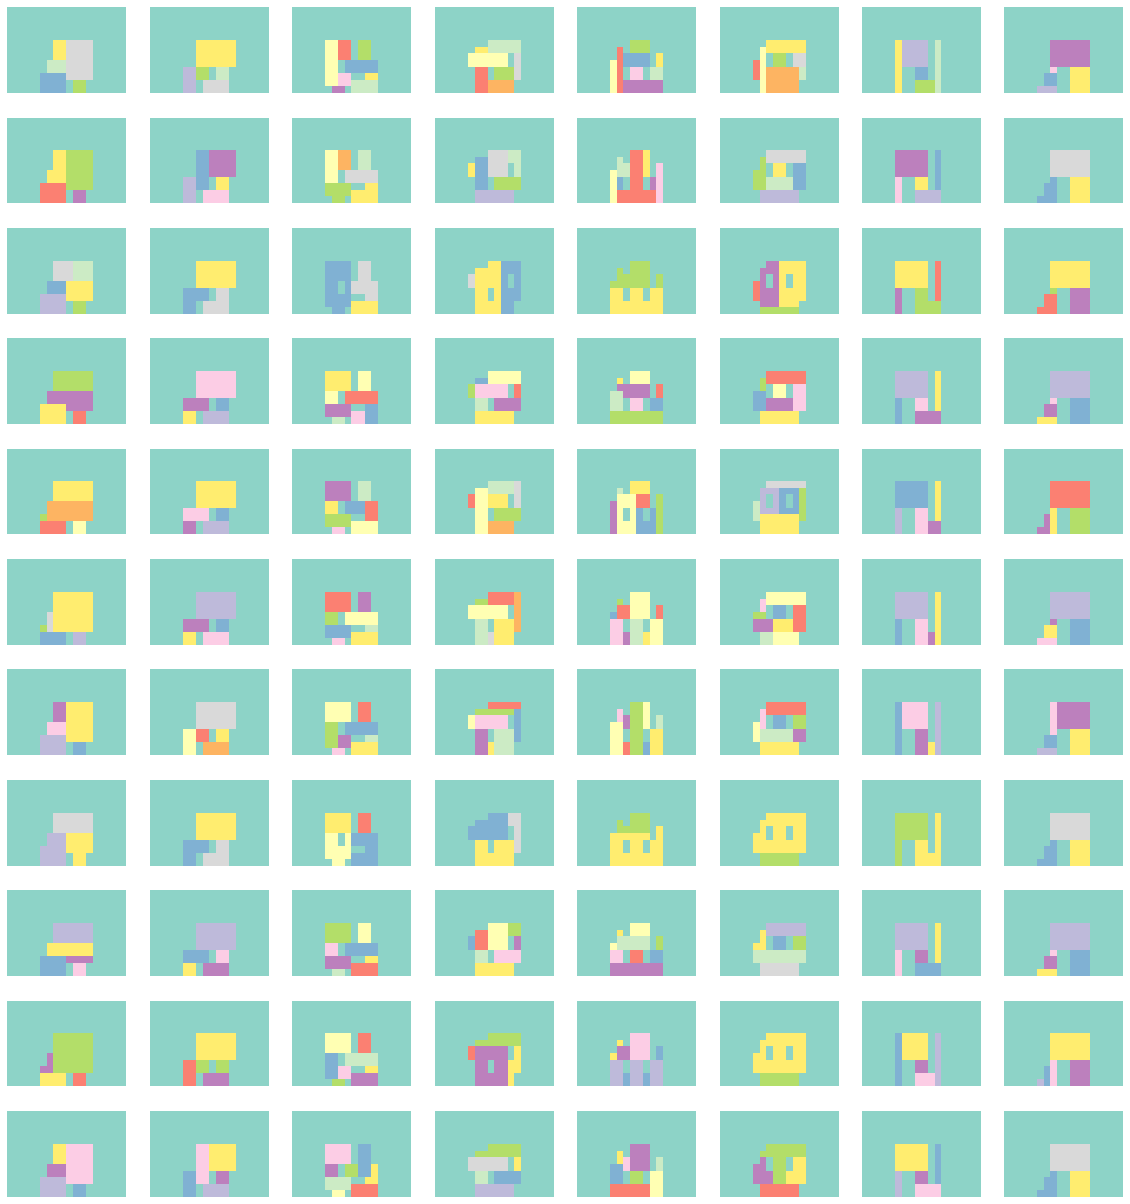

In [49]:
# visualize all participant's chunks

fig, axs = plt.subplots(n_ppt, numTrials, figsize=(20,2*n_ppt))

for i, ppt in enumerate(ppts):

    for j, target in enumerate(targets):

        chunks = df_trial[(df_trial.gameID==ppt) & (df_trial.targetName==target)]['gameGrid'].iloc[0]
        chunks = np.rot90(chunks)
        axs[i,j].axis('off')
        axs[i,j].imshow(chunks, cmap='Set3')

## Chunk analyses to run


### Properties of the chunk painting process
- size of chunk colored in over time
    - distinguish adding to the same chunk from creating new ones
- average position of colored square over trial
    - is it bottom to top?


### Perceptual chunks as predictors of difficulty/ complexity
- Number of perceptual chunks in each structure, as a measure of (perceptual) complexity
- Variance in perceptual chunks as a measure of 'knowing what to do first' when building (e.g. thinking time pre first block)
    - Calculate from edit distance (like we did with action sequences)
- Proportion of perceptual chunks that can't be made with blocks provided (as a measure of difficulty)

### Strategies for comparing perceptual chunks with procedural chunks
- Proportion of perceptual chunks that are also procedural chunks
    - i.e. get the overlap in distributions
    - Would need to think about chunk sizes, as well as popularity: don't want to be systematically skimming-off the procedural chunks that could match.
    - As a measure of difficulty?
- Find a unique 'median' perceptual decomposition


#### Once we have a metric:
- Pre vs. in post: do people start off with perceptual chunks but move on to procedural ones?


### Future analyses and experiments 
- are perceptual parses stable?
    - do they become more so after practice building
    




## Properties of chunk painting process

The main purpose of this experiment was to obtain perceptual decompositions. The process of recording them is less relevant to our goals, however we include some basic analyses.

#### Notes about data generation process:

- To add a chunk people could either click once to change the color on one square (colorType='click') or drag color from a square (colorType='drag'). If they dragged from an empty square, the color would auto-increment to a new color. Clicks on individual squares cycle through colors, so we expect many more clicks than drags.
- People may also overwrite previously colored squares. Therefore the recording of one particular chunk may span several color events, and may also be distributed among other coloring events unrelated to that chunk.

- For each coloring event, we record the squares changed, the new color group (1-8), the number of chunks currently highlighted (number of colors on shape not including the default grey), and 




In [76]:
df_color.colorType

0        drag
1        drag
2        drag
3        drag
4        drag
        ...  
1449     drag
1450    click
1451    click
1452     drag
1453     drag
Name: colorType, Length: 1454, dtype: object

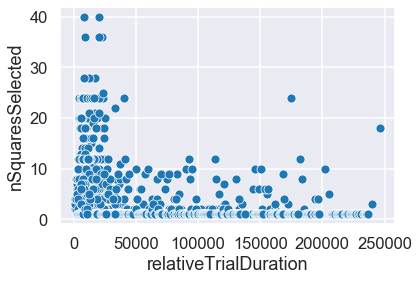

In [21]:
# how many grid-squares selected?

sns.scatterplot(data=df_color, x='relativeTrialDuration', y='nSquaresSelected')

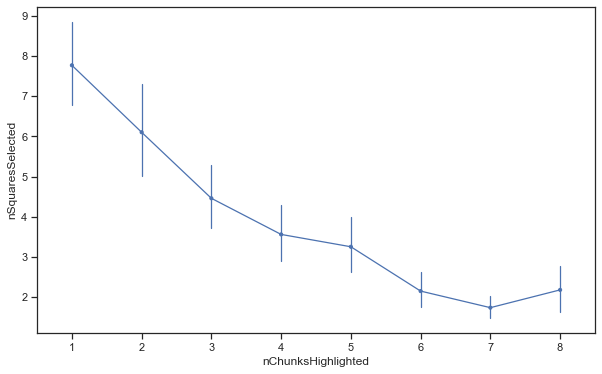

In [73]:
# do people highlight the largest chunks first?
# although- nChunksHighlighted isn't the same as finishing a chunk. 
# e.g. nChunks hilighted stays the same if you just extend a chunk a little bit. So larger n will be smaller

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.pointplot(data=df_color, x='nChunksHighlighted', y='nSquaresSelected')
#sns.swarmplot(data=df_color, x='nChunksHighlighted', y='nSquaresSelected')

## Perceptual chunks as predictors of difficulty/ complexity

### Number of perceptual chunks in each structure

<Figure size 720x432 with 0 Axes>

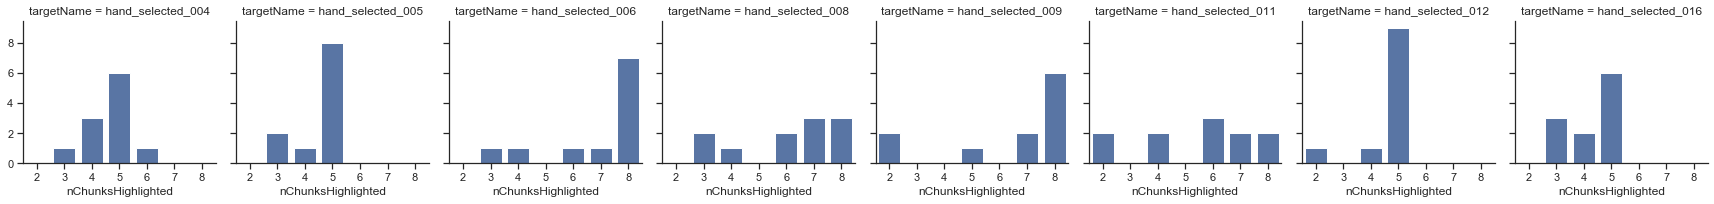

In [60]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_trial, col="targetName", col_order=targets)
g.map(sns.countplot, "nChunksHighlighted", order=range(2,9));

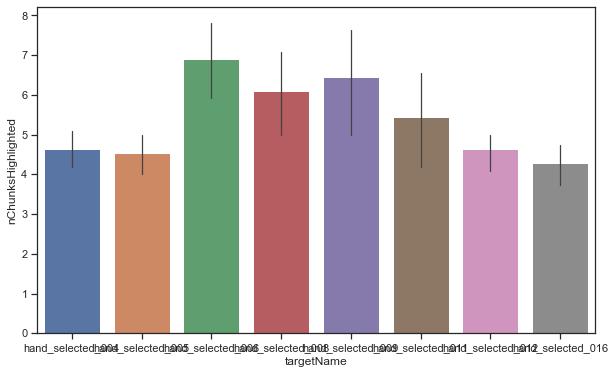

In [63]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.barplot(data=df_trial, y='nChunksHighlighted',x='targetName', order=targets)

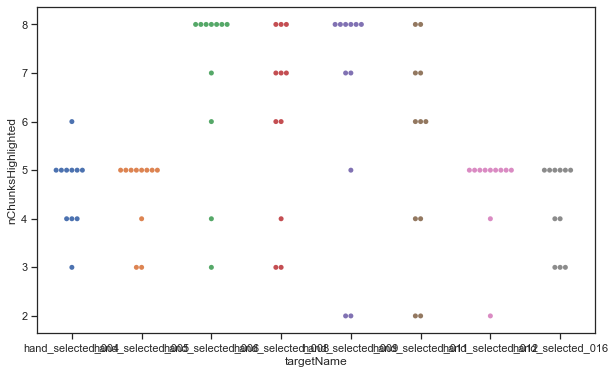

In [61]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.swarmplot(data=df_trial, y='nChunksHighlighted',x='targetName', order=targets)